# Linear regression para uma relação não linear de recursos-alvo

No exercício anterior, você foi solicitado a treinar um modelo de regressão linear
em um conjunto de dados onde os `dados` da matriz e o` alvo` vetorial não têm um
link linear.

Neste notebook, mostramos que mesmo que a parametrização de modelos lineares
não está adaptado nativamente ao problema em questão, ainda é possível fazer
modelos lineares mais expressivos por recursos adicionais de engenharia.

Um pipeline de aprendizado de máquina que combina uma engenharia de recursos não linear
etapa seguida por uma etapa de regressão linear pode, portanto, ser considerada
modelo de regressão não linear como um todo.

Para ilustrar esses conceitos, vamos reutilizar o mesmo conjunto de dados gerado no
exercício anterior.

In [1]:
import numpy as np

rng = np.random.RandomState(0)

n_sample = 100
data_max, data_min = 1.4, -1.4
len_data = (data_max - data_min)
# sort the data to make plotting easier later
data = np.sort(rng.rand(n_sample) * len_data - len_data / 2)
noise = rng.randn(n_sample) * .3
target = data ** 3 - 0.5 * data ** 2 + noise

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Para facilitar a plotagem, criaremos um dataframe do pandas contendo os dados
e alvo: </p>
</div>

In [2]:
import pandas as pd

full_data = pd.DataFrame({"input_feature": data, "target": target})

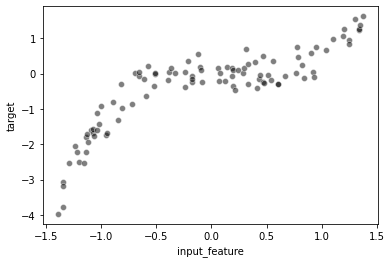

In [3]:
import seaborn as sns

_ = sns.scatterplot(data=full_data, x="input_feature", y="target",
                    color="black", alpha=0.5)

Vamos destacar as limitações de ajustar um modelo de regressão linear como
feito no exercício anterior.

<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p class="last">In scikit-learn, por convenção <tt class = "docutils literal"> dados </tt> (também chamado de <tt class = "docutils literal"> X </tt> no scikit-learn
documentação) deve ser uma matriz 2D de forma <tt class = "docutils literal"> (n_samples, n_features) </tt>.
Se <tt class = "docutils literal"> dados </tt> for um vetor 1D, você precisará reformulá-lo em uma matriz com um
coluna única se o vetor representa um recurso ou uma única linha se o
vetor representa uma amostra. </p>
</div>

In [5]:
# X should be 2D for sklearn: (n_samples, n_features)
data = data.reshape((-1, 1))
data.shape

(100, 1)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
linear_regression.fit(data, target)
target_predicted = linear_regression.predict(data)

In [7]:
mse = mean_squared_error(target, target_predicted)

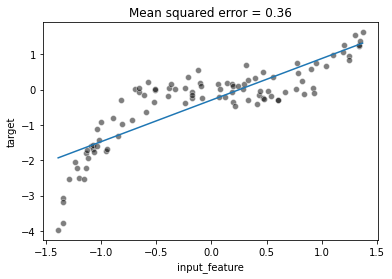

In [8]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

Aqui, o coeficiente e a interceptação aprendidos por `LinearRegression` definem o
melhor "linha reta" que se ajusta aos dados. Podemos inspecionar os coeficientes
usando os atributos do modelo aprendidos da seguinte forma:

In [9]:
print(f"weight: {linear_regression.coef_[0]:.2f}, "
      f"intercept: {linear_regression.intercept_:.2f}")

weight: 1.18, intercept: -0.29


É importante notar que o modelo aprendido não será capaz de lidar com o
relação não linear entre `dados` e` destino` desde modelos lineares
suponha que a relação entre `dados` e` destino` seja linear.

Na verdade, existem 3 possibilidades para resolver este problema:

1. escolher um modelo que possa lidar nativamente com a não linearidade,
2. projetar um conjunto mais rico de recursos, incluindo conhecimento especializado que pode
   ser usado diretamente por um modelo linear simples, ou
3. use um "kernel" para ter uma função de decisão baseada localmente em vez de um
   função de decisão linear global.

Vamos ilustrar rapidamente o primeiro ponto usando um regressor de árvore de decisão
que pode lidar nativamente com a não linearidade.

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3).fit(data, target)
target_predicted = tree.predict(data)
mse = mean_squared_error(target, target_predicted)

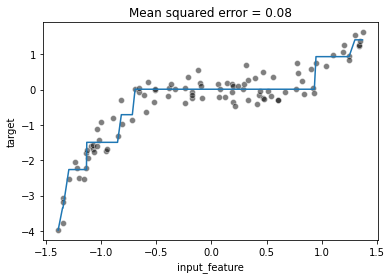

In [11]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

Em vez de ter um modelo que pode lidar nativamente com a não linearidade, nós
também poderia modificar nossos dados: poderíamos criar novos recursos, derivados do
características originais, usando algum conhecimento especializado. Neste exemplo, sabemos que
temos uma relação cúbica e quadrada entre `dados` e` destino` (porque
geramos os dados).

Na verdade, poderíamos criar dois novos recursos (`dados ** 2` e` dados ** 3`) usando
esta informação da seguinte forma. Este tipo de transformação é chamado de
expansão de recurso polinomial:

In [12]:
data.shape

(100, 1)

In [13]:
data_expanded = np.concatenate([data, data ** 2, data ** 3], axis=1)
data_expanded.shape

(100, 3)

In [14]:
linear_regression.fit(data_expanded, target)
target_predicted = linear_regression.predict(data_expanded)
mse = mean_squared_error(target, target_predicted)

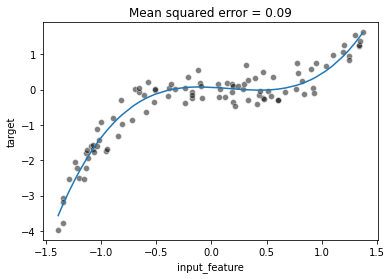

In [15]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

Podemos ver que mesmo com um modelo linear, podemos superar a linearidade
limitação do modelo, adicionando os componentes não lineares no projeto de
características adicionais. Aqui, criamos novos recursos conhecendo a forma como o
alvo foi gerado.

Em vez de criar manualmente esses recursos polinomiais, poderia usar diretamente
[sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

Para demonstrar o uso da classe `PolynomialFeatures`, usamos um
pipeline scikit-learn que primeiro transforma os recursos e depois se ajusta ao
modelo de regressão.

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression(),
)
polynomial_regression.fit(data, target)
target_predicted = polynomial_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

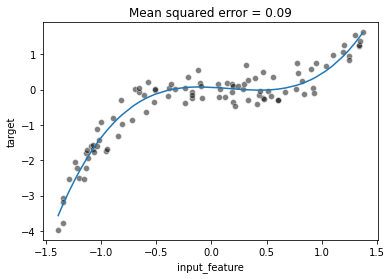

In [17]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

Como esperado, observamos que as previsões deste `PolynomialFeatures`
pipeline coincidir com as previsões do ajuste do modelo linear em engenharia manual
recursos.

A última possibilidade é tornar um modelo linear mais expressivo é usar um
"núcleo". Em vez de aprender um peso por recurso, como anteriormente
enfatizado, um peso será atribuído por amostra. No entanto, nem todos
amostras serão usadas. Esta é a base da máquina de vetores de suporte
algoritmo.

A definição matemática de "kernels" e "máquinas de vetores de suporte" é
além do escopo deste curso. Encorajamos os leitores interessados com um
treinamento matemático para dar uma olhada no scikit-learn [documentação sobre
SVMs](https://scikit-learn.org/stable/modules/svm.html) para obter mais detalhes.

Para o resto de nós, vamos apenas desenvolver algumas intuições sobre o
poder expressivo das máquinas de vetores de suporte linear e não linear
kernels ajustando-os no mesmo conjunto de dados.

Primeiro, considere uma máquina de vetores de suporte com um kernel linear:

In [18]:
from sklearn.svm import SVR

svr = SVR(kernel="linear")
svr.fit(data, target)
target_predicted = svr.predict(data)
mse = mean_squared_error(target, target_predicted)

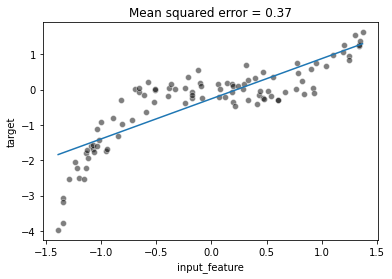

In [19]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

As previsões do nosso SVR com um kernel linear estão todas alinhadas em uma linha reta
linha. `SVR (kernel =" linear ")` é de fato mais um exemplo de um modelo linear.

O estimador também pode ser configurado para usar um kernel não linear. Então, pode
aprender uma função de previsão que calcula a interação não linear entre
amostras para as quais queremos fazer uma previsão e amostras selecionadas do
conjunto de treinamento.

O resultado é outro tipo de modelo de regressão não linear com uma
expressividade como nosso pipeline de regressão polinomial anterior:

In [20]:
svr = SVR(kernel="poly", degree=3)
svr.fit(data, target)
target_predicted = svr.predict(data)
mse = mean_squared_error(target, target_predicted)

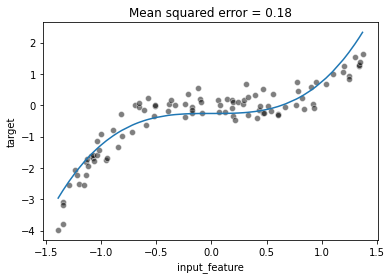

In [21]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

Os métodos de kernel, como SVR, são muito eficientes para conjuntos de dados pequenos e médios.

Para conjuntos de dados maiores com `n_samples >> 10_000`, é frequentemente computacionalmente
mais eficiente para realizar expansão explícita de recursos usando
`PolynomialFeatures` ou outros transformadores não lineares do scikit-learn como
Como
[KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html)
ou
[Nystroem](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html).

Aqui, novamente, referimos o leitor interessado à documentação para obter uma
definição adequada desses métodos. O que se segue apenas dá uma visão intuitiva
visão geral das previsões que obteríamos usando em nosso conjunto de dados de brinquedos:

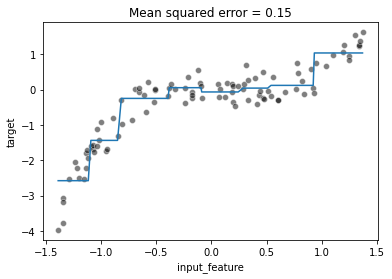

In [22]:
from sklearn.preprocessing import KBinsDiscretizer

binned_regression = make_pipeline(
    KBinsDiscretizer(n_bins=8), LinearRegression(),
)
binned_regression.fit(data, target)
target_predicted = binned_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

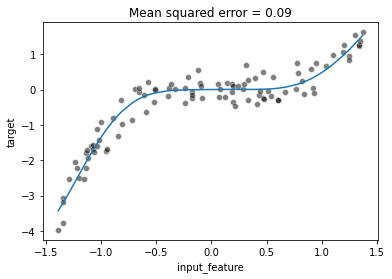

In [23]:
from sklearn.kernel_approximation import Nystroem

nystroem_regression = make_pipeline(
    Nystroem(n_components=5), LinearRegression(),
)
nystroem_regression.fit(data, target)
target_predicted = nystroem_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Mean squared error = {mse:.2f}")

# 📝 Exercício M4.03

Em todos os notebooks anteriores, usamos apenas um único recurso em `dados`. Mas nós
já mostramos que poderíamos adicionar novos recursos para tornar o modelo mais
expressivo derivando novos recursos, com base no recurso original.

O objetivo deste notebook é treinar um algoritmo de regressão linear em um
conjunto de dados mais do que um único recurso.

Carregaremos um conjunto de dados sobre os preços das casas na Califórnia.
O conjunto de dados consiste em 8 recursos relacionados à demografia e geografia de
distritos da Califórnia e o objetivo é prever o preço médio da casa de
cada distrito. Usaremos todos os 8 recursos para prever o alvo, a mediana
preço da casa.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Se você quiser uma visão geral mais aprofundada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC.</p>
</div>

In [24]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Agora é sua vez de treinar um modelo de regressão linear neste conjunto de dados.
Você vai precisar:
* criar um modelo de regressão linear;
* execute uma validação cruzada com 10 dobras e use o erro absoluto médio
  (MAE) como métrica. Certifique-se de retornar os estimadores ajustados;
* calcule a média e o padrão do MAE em milhares de dólares (k $);
* mostra os valores dos coeficientes para cada característica usando um boxplot por
  inspecionar o modelo ajustado retornado da validação cruzada. Dica: você
  use a função
  [`df.plot.box ()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.box.html)
  para traçar um gráfico de caixa.

Agora é sua vez de treinar um modelo de regressão linear neste conjunto de dados. Primeiro, crie um modelo de regressão linear.

In [25]:
# solution
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()

Execute uma validação cruzada com 10 dobras e use o erro absoluto médio (MAE) como métrica. Certifique-se de retornar os estimadores ajustados.

In [26]:
# solution
from sklearn.model_selection import cross_validate

cv_results = cross_validate(linear_regression, data, target,
                            scoring="neg_mean_absolute_error",
                            return_estimator=True, cv=10, n_jobs=2)

Calcule a média e o padrão do MAE em milhares de dólares (k $).

In [27]:
# solution
print(f"Mean absolute error on testing set: "
      f"{-cv_results['test_score'].mean():.3f} k$ +/- "
      f"{cv_results['test_score'].std():.3f}")

Mean absolute error on testing set: 54.452 k$ +/- 9.109


Inspecione o modelo ajustado usando um gráfico de caixa para mostrar a distribuição de valores para os coeficientes retornados da validação cruzada. Dica: use a função df.plot.box () para criar um gráfico de caixa.

In [28]:
# solution
import pandas as pd

weights = pd.DataFrame(
    [est.coef_ for est in cv_results["estimator"]], columns=data.columns)

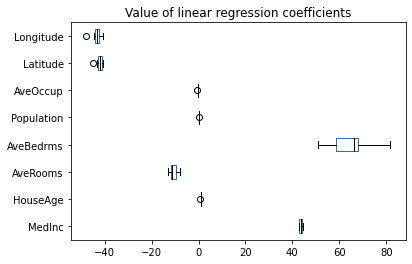

In [29]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights.plot.box(color=color, vert=False)
_ = plt.title("Value of linear regression coefficients")